In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

C:\Users\Andrew Hayman\PycharmProjects\Hybrid_Network_Models\venv\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Andrew Hayman\PycharmProjects\Hybrid_Network_Models\venv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


# MNIST Model

## Data Preprocessing

In [2]:
# Load data from MNIST dataset 
training_data = torchvision.datasets.MNIST("root", train=True, download=True, transform=ToTensor())
testing_data = torchvision.datasets.MNIST("root", train=False, download=True, transform=ToTensor())

In [3]:
# Only do 0's and 1's
#training_data.data = training_data.data[training_data.targets<=1]
#training_data.targets = training_data.targets[training_data.targets<=1]

In [4]:
# Display information on datasets
print("Training data size:\t ", training_data.data.size())
print("Testing data size:\t ", testing_data.data.size())

Training data size:	  torch.Size([60000, 28, 28])
Testing data size:	  torch.Size([10000, 28, 28])


Text(0.5, 1.0, '5')

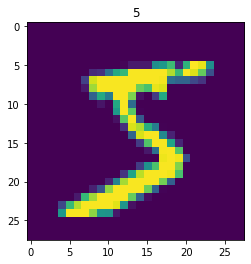

In [5]:
# Display a sample
plt.imshow(training_data.data[0])
plt.title('%i' % training_data.targets[0])

In [6]:
# Prepare subset of data and shuffle
train_dataloader = DataLoader(training_data, batch_size = 500, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size = 100, shuffle=True)

In [10]:
# Showcase dataloader information
for batch, (images, labels) in enumerate(train_dataloader): 
    print(batch)
    print(images.size())
    print(images.view(images.shape[0], -1).size())
    print(labels.size())
    break

0
torch.Size([500, 1, 28, 28])
torch.Size([500, 784])
torch.Size([500])


In [11]:
test = torch.nn.functional.one_hot(training_data.targets)
print(test[0])

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


## Network Design and Parameters

In [7]:
n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='torch', diff_method="adjoint")
def qnode_3_amplitudes(inputs, weights):
    
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.RY(inputs[2], wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[1, 2])
    
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.RY(weights[2], wires=2)

    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))

weight_shapes = {"weights": 3}
qlayer_3_amplitudes = qml.qnn.TorchLayer(qnode_3_amplitudes, weight_shapes)

qlayer_3_amplitudes(torch.Tensor([1,3,3]))

tensor([-0.9268,  0.8027, -0.0398], grad_fn=<ToCopyBackward0>)

In [13]:
# Define neural network 
# Great source: https://pennylane.ai/qml/demos/tutorial_qnn_module_torch.html
# Note that in_channels = 1 because the input is a grayscale image
from itertools import combinations


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(in_features=784, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=12),
        )
        
        self.final = nn.Sequential(nn.Linear(in_features=12, out_features=10),
                                    nn.ReLU(),
                                    nn.Linear(in_features=10, out_features=10),
                                    nn.LogSoftmax(dim=1))
    

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.main(x)
        x_split = torch.split(x, 1, dim=1)
        x_split = list(x_split)

        x_out = []
        
        for i in range(0, 4):
            i=i*3
            x_temp = torch.cat([x_split[i], x_split[i+1], x_split[i+2]], dim=1)
            x_temp = qlayer_3_amplitudes(x_temp)
            x_out.append(x_temp)
        
        x = torch.cat(x_out, dim=1)
        x = self.final(x)
        return x

In [14]:
# View neural network 
model = Net()
#test = training_data.data[0:100]
#test = test.view(-1, 784)
#test = test/2.0
#y = model.forward(test)
#print(y)

In [15]:
#from torchsummary import summary
#summary(model, (1, 28, 28))

## Training the Model

In [16]:
# Define training routine
import time

def train(epochs):
    epoch_list = []
    accuracy_list = []
    loss_list = []
    for epoch in range(1, epochs+1):
        accuracy = 0
        running_loss = 0

        for batch_idx, (image, labels) in enumerate(train_dataloader):
            start = time.time()
            output = model(image)                           # Find network output
            loss = loss_function(output, labels)              # Compute loss

            predicted = torch.max(output.data, 1)[1]          # Find predicted value
            batch_corr = (predicted == labels).sum()          # Find number of correct values
            batch_accuracy = (100*batch_corr / len(labels))    
            accuracy+=batch_accuracy/120
            running_loss += loss.item()

            optimizer.zero_grad()                             # Clear gradients for this training step
            loss.backward()                                   # Compute gradients from backpropagation 
            optimizer.step()                                  # Apply changes from gradients
            end = time.time()
            print("Batch accuracy: %.2f Time: %.2f" % (batch_accuracy, (end - start)))

        print("Training accuracy: %.2f \t Training loss: %.2f " % (accuracy, running_loss))
        epoch_list.append(epoch)
        accuracy_list.append(accuracy)
        loss_list.append(running_loss)
    return epoch_list, accuracy_list, loss_list
        

In [17]:
# Run training
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs, accuracy, loss = train(epochs=10)

Batch accuracy: 7.80 Time: 11.84
Batch accuracy: 10.20 Time: 11.88
Batch accuracy: 10.40 Time: 11.84
Batch accuracy: 10.20 Time: 12.33
Batch accuracy: 20.00 Time: 12.29
Batch accuracy: 20.40 Time: 12.04
Batch accuracy: 24.40 Time: 12.10
Batch accuracy: 21.00 Time: 11.94
Batch accuracy: 22.40 Time: 11.92
Batch accuracy: 24.00 Time: 11.96
Batch accuracy: 20.20 Time: 12.02
Batch accuracy: 22.40 Time: 11.96
Batch accuracy: 33.20 Time: 11.97
Batch accuracy: 28.40 Time: 12.10
Batch accuracy: 33.80 Time: 12.15
Batch accuracy: 31.40 Time: 12.26
Batch accuracy: 34.60 Time: 11.90
Batch accuracy: 30.60 Time: 12.00
Batch accuracy: 30.60 Time: 12.91
Batch accuracy: 27.20 Time: 11.85
Batch accuracy: 30.00 Time: 11.69
Batch accuracy: 34.60 Time: 11.85
Batch accuracy: 33.40 Time: 11.92
Batch accuracy: 36.00 Time: 11.87
Batch accuracy: 33.80 Time: 11.77
Batch accuracy: 36.40 Time: 12.01
Batch accuracy: 39.20 Time: 11.87
Batch accuracy: 41.80 Time: 11.90
Batch accuracy: 49.60 Time: 11.85
Batch accuracy:

Batch accuracy: 95.80 Time: 12.01
Batch accuracy: 96.80 Time: 11.83
Batch accuracy: 97.60 Time: 11.91
Batch accuracy: 96.00 Time: 11.84
Batch accuracy: 97.00 Time: 11.79
Batch accuracy: 97.60 Time: 11.84
Batch accuracy: 96.60 Time: 12.08
Batch accuracy: 98.40 Time: 11.77
Batch accuracy: 98.40 Time: 11.82
Batch accuracy: 96.80 Time: 11.93
Batch accuracy: 97.20 Time: 12.00
Batch accuracy: 97.60 Time: 11.77
Batch accuracy: 96.40 Time: 11.96
Batch accuracy: 97.40 Time: 12.11
Batch accuracy: 97.00 Time: 12.11
Batch accuracy: 96.40 Time: 12.15
Batch accuracy: 98.00 Time: 12.32
Batch accuracy: 96.80 Time: 12.23
Batch accuracy: 96.60 Time: 12.24
Batch accuracy: 98.40 Time: 12.23
Batch accuracy: 97.60 Time: 12.25
Batch accuracy: 97.00 Time: 12.08
Batch accuracy: 96.80 Time: 12.03
Batch accuracy: 98.20 Time: 12.51
Batch accuracy: 96.20 Time: 11.95
Batch accuracy: 96.60 Time: 12.07
Batch accuracy: 96.20 Time: 11.89
Batch accuracy: 98.60 Time: 12.10
Batch accuracy: 97.20 Time: 11.90
Batch accuracy

Batch accuracy: 98.80 Time: 11.95
Batch accuracy: 98.20 Time: 11.90
Batch accuracy: 98.00 Time: 11.90
Batch accuracy: 98.60 Time: 11.93
Batch accuracy: 98.20 Time: 12.06
Batch accuracy: 99.00 Time: 11.83
Batch accuracy: 97.60 Time: 11.84
Batch accuracy: 96.80 Time: 11.94
Batch accuracy: 97.60 Time: 12.07
Batch accuracy: 97.00 Time: 11.98
Batch accuracy: 98.60 Time: 11.97
Batch accuracy: 97.80 Time: 12.13
Batch accuracy: 98.00 Time: 12.03
Batch accuracy: 98.00 Time: 12.04
Batch accuracy: 97.40 Time: 11.78
Batch accuracy: 98.00 Time: 11.77
Batch accuracy: 98.20 Time: 11.87
Batch accuracy: 97.40 Time: 11.92
Batch accuracy: 97.20 Time: 11.83
Batch accuracy: 97.80 Time: 11.95
Batch accuracy: 98.20 Time: 11.81
Batch accuracy: 97.00 Time: 11.87
Batch accuracy: 98.00 Time: 11.89
Batch accuracy: 96.80 Time: 11.88
Batch accuracy: 97.20 Time: 11.79
Batch accuracy: 97.60 Time: 12.05
Batch accuracy: 97.20 Time: 12.13
Batch accuracy: 97.40 Time: 12.09
Batch accuracy: 96.00 Time: 11.98
Batch accuracy

Batch accuracy: 98.60 Time: 12.07
Batch accuracy: 97.80 Time: 11.96
Batch accuracy: 98.40 Time: 11.74
Batch accuracy: 98.60 Time: 12.05
Batch accuracy: 97.80 Time: 11.98
Batch accuracy: 98.80 Time: 11.82
Batch accuracy: 99.20 Time: 12.02
Batch accuracy: 97.60 Time: 12.07
Batch accuracy: 99.20 Time: 12.21
Batch accuracy: 98.40 Time: 12.07
Batch accuracy: 98.20 Time: 12.03
Batch accuracy: 98.40 Time: 11.98
Batch accuracy: 98.60 Time: 11.76
Batch accuracy: 99.20 Time: 11.83
Batch accuracy: 98.80 Time: 11.86
Batch accuracy: 98.80 Time: 11.84
Batch accuracy: 99.40 Time: 11.97
Batch accuracy: 99.20 Time: 11.91
Batch accuracy: 98.60 Time: 11.67
Batch accuracy: 97.20 Time: 11.97
Batch accuracy: 99.00 Time: 12.35
Batch accuracy: 99.40 Time: 12.02
Batch accuracy: 97.80 Time: 11.93
Batch accuracy: 99.40 Time: 11.83
Batch accuracy: 98.60 Time: 11.88
Batch accuracy: 98.80 Time: 11.91
Batch accuracy: 97.60 Time: 11.90
Batch accuracy: 98.60 Time: 11.96
Batch accuracy: 99.20 Time: 11.91
Batch accuracy

Batch accuracy: 98.80 Time: 11.97
Batch accuracy: 98.80 Time: 12.20
Batch accuracy: 98.80 Time: 11.97
Batch accuracy: 98.60 Time: 11.77
Batch accuracy: 99.40 Time: 11.92
Batch accuracy: 99.40 Time: 11.97
Batch accuracy: 98.40 Time: 11.90
Batch accuracy: 98.20 Time: 11.84
Batch accuracy: 99.80 Time: 11.98
Batch accuracy: 97.80 Time: 11.83
Batch accuracy: 97.60 Time: 11.92
Batch accuracy: 99.20 Time: 11.80
Batch accuracy: 98.60 Time: 11.74
Batch accuracy: 97.80 Time: 11.98
Batch accuracy: 97.60 Time: 11.92
Batch accuracy: 98.80 Time: 11.82
Batch accuracy: 98.00 Time: 12.03
Batch accuracy: 99.20 Time: 12.01
Batch accuracy: 99.20 Time: 12.00
Batch accuracy: 99.00 Time: 11.87
Batch accuracy: 98.40 Time: 11.94
Batch accuracy: 99.00 Time: 11.98
Batch accuracy: 97.80 Time: 11.90
Batch accuracy: 99.20 Time: 11.96
Batch accuracy: 99.60 Time: 11.96
Batch accuracy: 99.00 Time: 12.07
Batch accuracy: 98.40 Time: 12.15
Batch accuracy: 98.40 Time: 12.03
Batch accuracy: 97.80 Time: 11.98
Batch accuracy

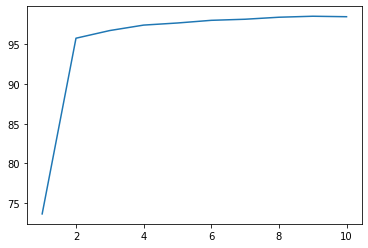

In [18]:
plt.plot(epochs, accuracy)

In [ ]:
plt.plot(epochs, accuracy)

## Testing the Model

In [ ]:
def test(): 
    accuracy = 0
    with torch.no_grad(): 
        for image, labels in enumerate(test_dataloader): 
            output = network(image)
            predicted = torch.max(output.data, 1)[1]
            accuracy += (100*(predicted == labels).sum() / len(labels))
    print("Accuracy: ", accuracy)

In [ ]:
test()

# Network Class

In [ ]:
class NN: 

In [ ]:
train_losses = []
train_counter = [] 
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
log_interval = 10

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [ ]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()